The outcome is a binary classification. Prompt suggests RandomForest to identify most predictive variables.

In [3]:
import pandas as pd
df = pd.read_csv("./data/customer_booking.csv", encoding="ISO-8859-1")
df = df.dropna()

Most impactful features in descending order: [('purchase_lead', 0.14570369924158577), ('flight_hour', 0.12038826924392326), ('length_of_stay', 0.11151299761099703), ('num_passengers', 0.04836639621156369), ('flight_duration', 0.03649971657587821)]
Fold 1 accuracy: 0.85
F1 score: 0.20634920634920634
Precision: 0.5186170212765957
Recall: 0.1287978863936592


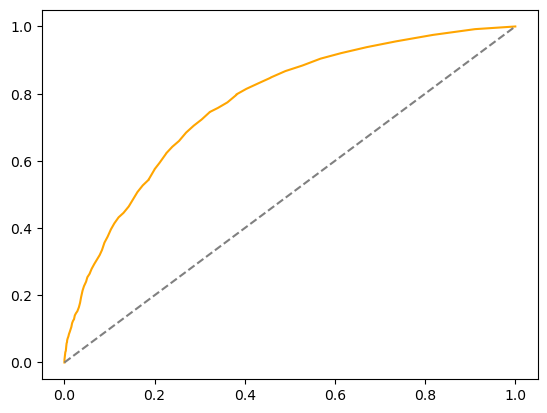

Most impactful features in descending order: [('purchase_lead', 0.1459754260193177), ('flight_hour', 0.12258933848775855), ('length_of_stay', 0.1095325267507459), ('num_passengers', 0.0456875672231438), ('flight_duration', 0.03790894341842404)]
Fold 2 accuracy: 0.8506
F1 score: 0.193304535637149
Precision: 0.50997150997151
Recall: 0.11925383077948035


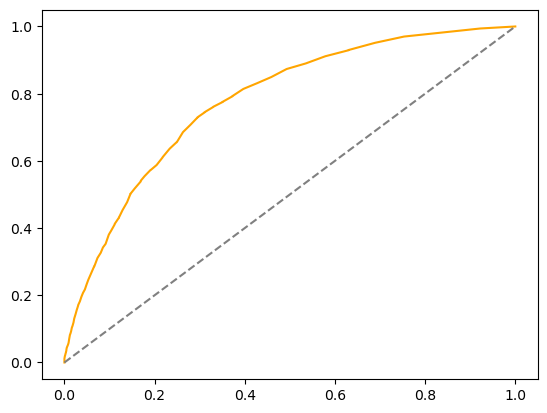

Most impactful features in descending order: [('purchase_lead', 0.14678210124097038), ('flight_hour', 0.12171906600749965), ('length_of_stay', 0.11190890204090273), ('num_passengers', 0.047821396264231444), ('flight_duration', 0.03733393614665278)]
Fold 3 accuracy: 0.8483
F1 score: 0.20283762480294273
Precision: 0.48860759493670886
Recall: 0.12798408488063662


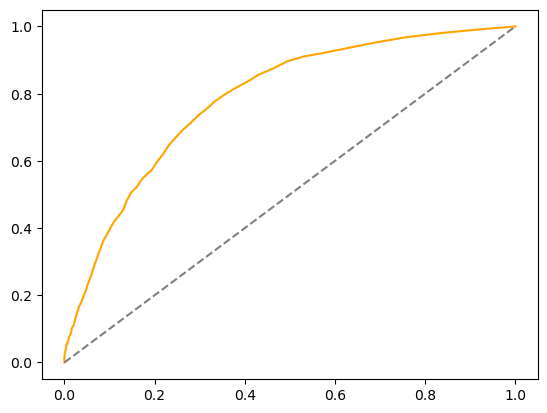

Most impactful features in descending order: [('purchase_lead', 0.1457657426057762), ('flight_hour', 0.1209472169910076), ('length_of_stay', 0.10995227228977682), ('num_passengers', 0.047206991412023704), ('flight_duration', 0.036071484797418854)]
Fold 4 accuracy: 0.8487
F1 score: 0.19220501868659903
Precision: 0.4986149584487535
Recall: 0.11904761904761904


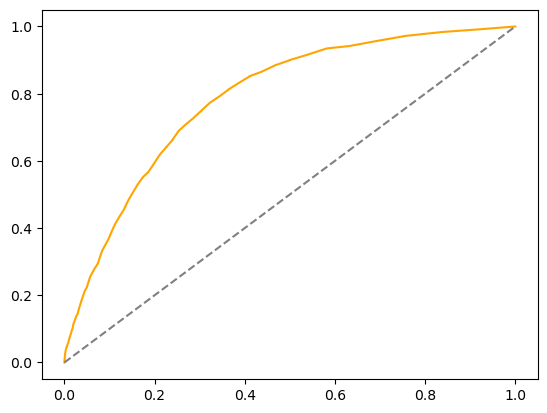

Most impactful features in descending order: [('purchase_lead', 0.14492044057931017), ('flight_hour', 0.1209328079155442), ('length_of_stay', 0.10983637626656559), ('num_passengers', 0.04660485181619311), ('flight_duration', 0.037727385616492894)]
Fold 5 accuracy: 0.8568
F1 score: 0.2053274139844617
Precision: 0.5153203342618384
Recall: 0.1282051282051282


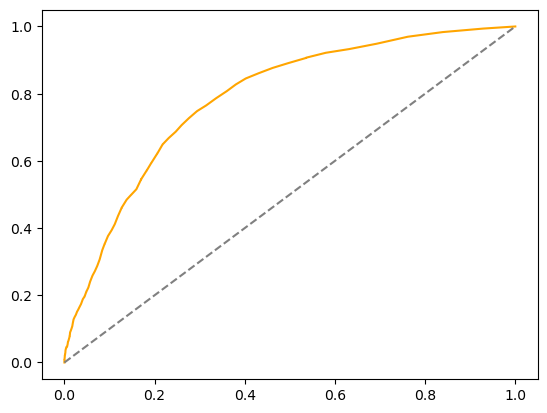

In [13]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

predictors = df.columns[:-1]
k = 5

kF = KFold(n_splits = k, shuffle = True)
clf = RandomForestClassifier()
enc = OneHotEncoder(sparse_output = False)

categorical = ['sales_channel',
                    'trip_type',
                    'flight_day',
                    'route',
                    'booking_origin']

x = df.drop(columns = ['booking_complete'])
# print(x.shape)

# using one-hot encoding for the categorical variables, and creating post encoded df
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html 
x_enc = enc.fit_transform(x[categorical])
x_enc_df = pd.DataFrame(x_enc, columns = enc.get_feature_names_out(categorical))
df_post_enc = pd.concat([x.drop(columns = categorical), x_enc_df,df['booking_complete']], axis = 1)

#need to rename the target variable after processing with one-hot encoding
df_post_enc.rename(columns = {0:'booking_complete'},inplace = True)
df_post_enc = df_post_enc.fillna('-1')

i=0
for train_index,test_index in kF.split(df_post_enc):
    
    train = df_post_enc.iloc[train_index]
    test = df_post_enc.iloc[test_index]
    
    y_train = train['booking_complete']
    x_train = train.drop(columns = ['booking_complete'])
    
    y_test = test['booking_complete']
    x_test = test.drop(columns = ['booking_complete'])
    
    clf.fit(x_train,y_train)
    
    feature_importance = sorted(list(zip(x_train.columns,clf.feature_importances_)),
                                key = lambda x: x[1], reverse = True)
    print("Most impactful features in descending order:", feature_importance[:5])
    print(f"Fold {i+1} accuracy:",clf.score(x_test,y_test))
    print("F1 score:",f1_score(y_test,clf.predict(x_test)))
    print("Precision:", precision_score(y_test,clf.predict(x_test)))
    print("Recall:", recall_score(y_test,clf.predict(x_test)))
    i += 1
    
    fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(x_test)[:,1])
    auroc = auc(fpr,tpr)
    
    plt.plot(fpr,tpr,color = 'orange')
    plt.plot([0,1],[0,1],color = 'grey', linestyle = "--")
    plt.show()
    
    #here I attempt to find the relationship between some of them via logistic regression
    # does not work...
#     logreg = LogisticRegression()
#     logreg.fit(x_train['purchase_lead'].values.reshape(-1,1),list(y_train))
    
#     x_axis = np.linspace(0,300,300).reshape(-1,1)
#     prob = logreg.predict_proba(x_axis)[:,1]
#     plt.scatter(list(x_train['purchase_lead']),y_train)
#     plt.plot(x_axis,prob)
#     plt.show()

    #maybe try a regular 2d plot and try to make sense of it by eye
    #nope. but it does seem that longer dates are less likely to be considered
#     plt.scatter(list(x_train['purchase_lead']),y_train)
#     plt.show


    